**Shruthan Radhakrishna** (**sr73@illinois.edu**) \
Team 52 - Project ID 65 \
Video Link: https://drive.google.com/file/d/1lMteQlHuGPeMWecexGQlvB00NEglXWJ4/view?usp=sharing \
Deep Learning Enables Accurate Diagnosis of Novel Coronavirus (COVID-19) With CT Images \
GitHub: https://github.com/shruthanr/dl4h


This notebook is designed to be run on Google Colab

In [ ]:
# Get project code
!git clone https://github.com/shruthanr/dl4h.git
%cd dl4h

Cloning into 'dl4h'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 31 (delta 8), reused 27 (delta 7), pack-reused 0
Receiving objects: 100% (31/31), 296.14 KiB | 3.44 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/dl4h


# Introduction
<!-- This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem). -->


**Background**

- This project aims to replicate the work in [[1]](https://pubmed.ncbi.nlm.nih.gov/33705321/) which aims to build a system for the *disease prediction* task of identify patients infected with COVID-19 using computed tomography (CT) scans.
- Such a model could aid medical professionals in faster diagnosis of COVID-19 by providing an additional data point on the likleihood of a patient having COVID-19 based on a simple CT scan.
- A major challenge to build such a system is the scarcity of annotated data. Valid concerns of confidentiality and privacy make large scale aggregation of such data difficult. A related challenge is the lack of diversity in the data since data is likely to have been from a few hospitals which are unlikley to capture the divesity in demographies of people around the world.
- A second challenge is the interpretability of the results. Uninterpretable results reduce confidence in the system when used in practice. Interpretable systems can aid further analysis/research on the relation between CT scans and COVID-19 diagnosis.
- While there is no clear state-of-the-art for COVID-19 detction using CT scans, most recent papers on predicting COVID-19 from either CT scans (3D) or Chest X-rays (2D) use some form of deep CNN model (like VGGNet, AlexNet, ResNet), and/or attention-based models like in  [[2]](https://www.mdpi.com/2078-2489/14/7/370)  [[3]](https://www.nature.com/articles/s41598-022-27266-9#citeas)   [[4]](https://www.sciencedirect.com/science/article/pii/S2665917422000265).

**Paper**

- The paper proposes a novel architecture in an attempt to maximize the amount of information extracted from the CT scans for downstream classification. Specifically,  uses a Feature Pyramid Network (FPN)  [[5]](https://arxiv.org/abs/1612.03144) along with a ResNet50 model  [[6]](https://arxiv.org/abs/1512.03385) to identify sub-images/objects (that may be potential lesions) in the CT scan image. The same ResNet50 model is used to extract features from the sub-images and relational features between the sub-images. These features are concatenated with some global features from the original CT-scan image (also extracted using the same shared ResNet50 model), and are used to predict if the given CT scan is likely to be of a COVID-19 patient. This architecture of using ResNet50 and FPN to extract features at different granularities is referred to as **DRENet**. Final predictions at the patient level are obtained by aggregating the prediction over each CT image slice of the patient.
- The paper claims its architecture perform better than other deep CNN models like VGG16, DenseNet, and ResNet, especially in terms ROC-AUC and Recall.
- Since data is scarce, it becomes important to maximize the amount of information extracted from each image. The propsed method using features at different granularities attempts to do the same.
- Authors provide their code at: https://github.com/SY575/COVID19-CT . The code in this project is adapted from their code and modified.

# Score of Reproducibility
I test the following hypotheses: for the task of binary classification into two classes - No COVID (class 0) and COVID (class 1):

1.   Hypothesis 1: DRENet (proposed in the paper) performs as well as is state in the paper.
2.   Hypothesis 2: DRENet performs better than ResNet for the same task, as suggested in the paper.

The paper also releases results for 3-class classification into (i) COVID-19, (ii) having Bacteria Pneumonia, or (iii) being Healthy. However, the dataset for such classification is unavailable, and hence will not be replicated.

<!-- You can insert images in this notebook text, [see this link](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive) and example below:

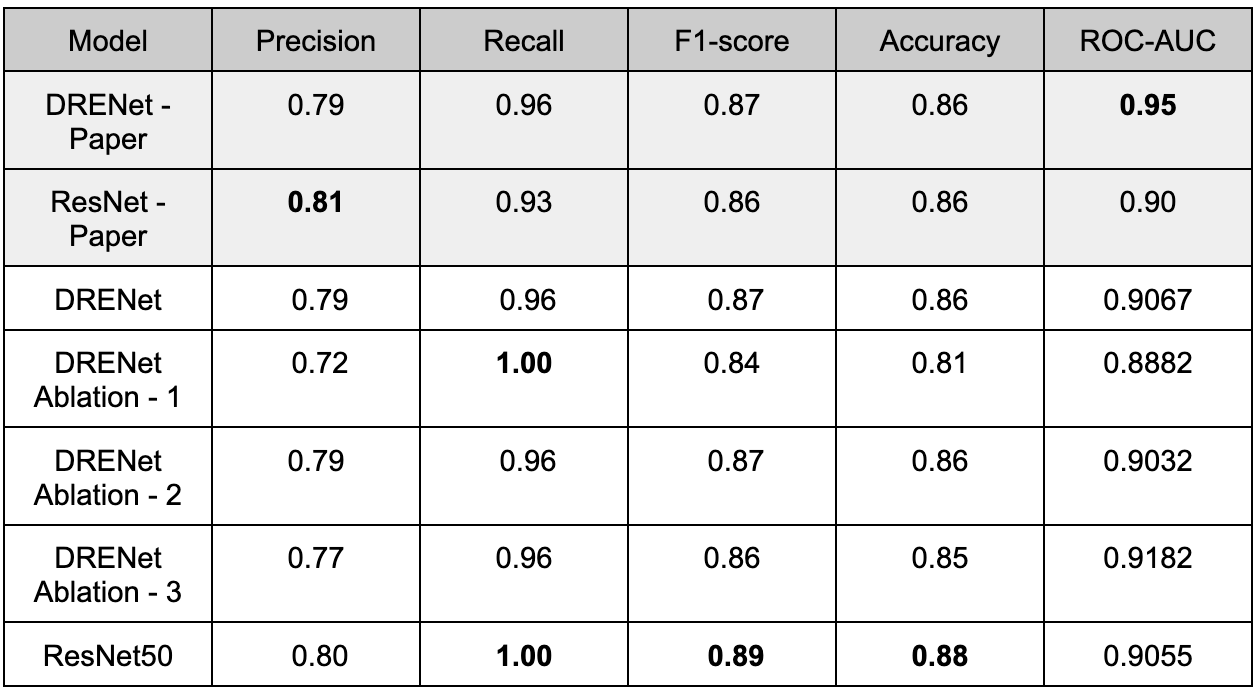![sample_image.png](https://drive.google.com/uc?export=view&id=1g2efvsRJDxTxKz-OY3loMhihrEUdBxbc) -->

# Methodology



In [ ]:
# import  packages you need
import os
import pickle
import random
from collections import defaultdict, OrderedDict
from datetime import datetime
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.misc
import torch
import torch.nn.functional as F
import torch.utils.data
import torchvision
from src import resnet, losses
from src.anchors import (cdds2attention_map, generate_default_anchor_maps,
                          hard_nms)
from src.data import SARS

from PIL import Image
from scipy.io import loadmat
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from torch import nn
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms, models
from tqdm import tqdm

In [ ]:
BATCH_SIZE = 4
PROPOSAL_NUM = 6
CAT_NUM = 6
INPUT_SIZE = (448, 448)
LR = 0.0008
WD = 1e-4
EVAL_FREQ = 1
resume = ''
test_model = 'model.ckpt'
save_dir = './'
random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##  Data
<!-- Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset. -->

### Download Data

- Training, validation, and testing data were provided publicly by the authors in the GitHub repository. The same been stored in a Google Drive and are downloaded and de-compressed below.
- **Note:** there seems to be an **error in the data released.** The folders containing the training and validation data have the exact same images suggesting that the training images have been mistakenly released in the validation data folder. For hyperparameter-tuning in the current project, 10% of the training data was used as the validation set. Once hyperparameters were finalized, the model was trained on the entire traning set.
- The function processing the data is present in `src/data.py` in the GitHub repository cloned at the top of this notebook

In [ ]:
!gdown 11LaohV5A_YrLKrrwnZQm26bGn7mMtvID
!gdown 1qAm5OW_noHmFL09lEYQ4YbmNPNSKQJaK
!gdown 1tycigPQUvf12HcsO4y15qUiRwXFgHsrI

!unzip -q train.zip
!unzip -q val.zip
!unzip -q test.zip

Downloading...
From: https://drive.google.com/uc?id=11LaohV5A_YrLKrrwnZQm26bGn7mMtvID
To: /content/dl4h/train.zip
100% 24.7M/24.7M [00:00<00:00, 82.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qAm5OW_noHmFL09lEYQ4YbmNPNSKQJaK
To: /content/dl4h/test.zip
100% 12.4M/12.4M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tycigPQUvf12HcsO4y15qUiRwXFgHsrI
To: /content/dl4h/val.zip
100% 24.7M/24.7M [00:00<00:00, 52.0MB/s]


In [ ]:
train_path = './train/'
val_path = './val/'
test_path = './test/'

train = SARS(root=train_path, is_train=True)
val = SARS(root=val_path, is_train=False)
test = SARS(root=test_path, is_train=False)



trainloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,
                                          shuffle=True, drop_last=False)
valloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE,
                                         shuffle=False, drop_last=False)
testloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,
                                         shuffle=False, drop_last=False)

### Image-level vs Person-level
As the paper mentions, a 3D CT images of one patient may contain more than 200 images. Neighbored images tend to be highly similar. Hence, 15 equidistant
representative images were chosen. Further images with lung regions occupying less than 50 percent of the total image were discarded.

It is important to note that the model is trained at the image-level i.e. the model takes a single CT scan image as input and predicts the probability of the image being of a person infected with COVID-19. The results however are reported at the person level - all images belonging to a person are passed through the model to get a score (probability) for each image, and the mean of these scores is used as the score (probability) for the person. This is depectied in the diagram below:

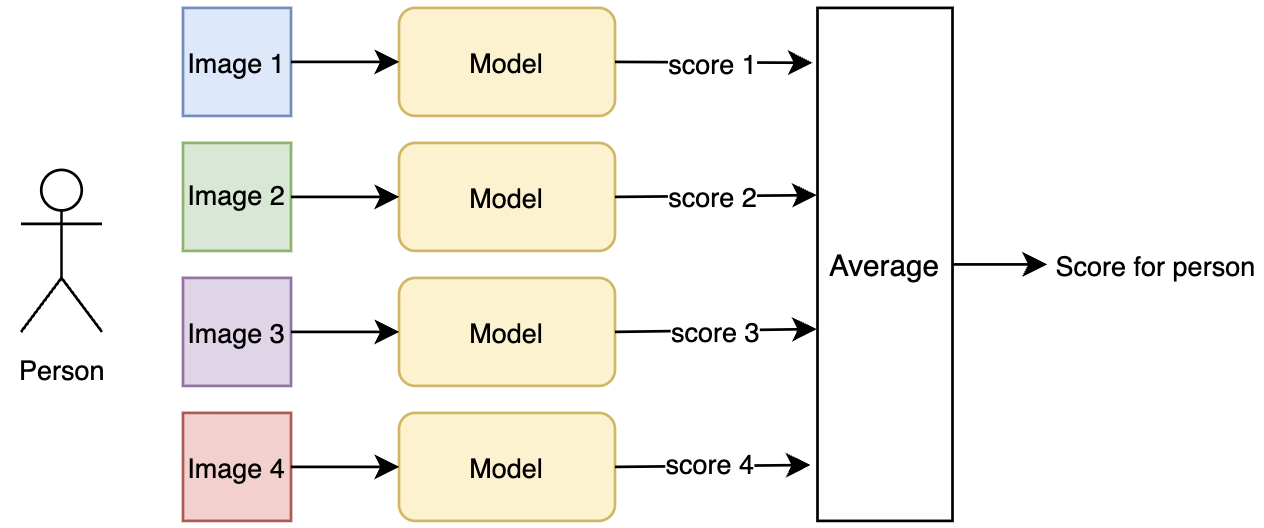

### Statistics
Below are some descriptive statistics of the provided data

In [ ]:
def get_person_wise_statistics(dataset):
    names = []
    for i in range(len(dataset)):
        names.append(dataset[i][3])

    no_covid, covid = 0, 0
    for name in list(set(names)):
        name_split = name.split("-")
        if len(name_split) == 4:
            no_covid += 1
        else:
            covid += 1
    return {
        "no_covid_count" : no_covid,
        "covid_count" : covid,
        "num_examples" : no_covid + covid
    }

In [ ]:
# Train - Val - Test Split - Image Level
print("Training set size", len(train))
print("Validation set size", len(val))
print("Testing set size", len(test))

Training set size 1148
Validation set size 1148
Testing set size 567


The size of the validation set being equal to the size of the training set shows the error in the data released

In [ ]:
train_stats_person_wise = get_person_wise_statistics(train)
val_stats_person_wise = get_person_wise_statistics(val)
test_stats_person_wise = get_person_wise_statistics(test)

In [ ]:
# Train - Val - Test Split - Person Level
print("Training set size", train_stats_person_wise["num_examples"])
print("Validation set size", val_stats_person_wise["num_examples"])
print("Testing set size", test_stats_person_wise["num_examples"])

Training set size 133
Validation set size 133
Testing set size 59


- This train-val-test split sizes above is on the slice level and not person level. For each person, there are multiple slices (images) from the 3D CT scan. According to the paper, the train-val-test split size at the person level is 60-10-30%. The training, validation, and testing splits above are provided as separate zip files by the authors of the paper, and have been used directly in this project.


- Label 0 represents cases of No COVID and label 1 represents cases of COVID


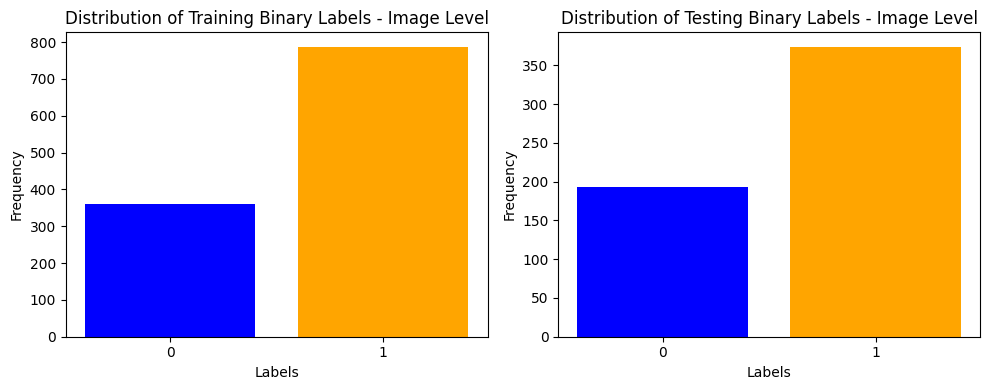

In [ ]:
# Label distribution - Image Level
train_labels = train.get_labels()
test_labels = test.get_labels()
train_unique_labels, train_label_counts = np.unique(train_labels, return_counts=True)
test_unique_labels, test_label_counts = np.unique(test_labels, return_counts=True)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].bar(train_unique_labels, train_label_counts, tick_label=train_unique_labels, color=['blue', 'orange'])
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Training Binary Labels - Image Level')


axs[1].bar(test_unique_labels, test_label_counts, tick_label=test_unique_labels, color=['blue', 'orange'])
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Testing Binary Labels - Image Level')

plt.tight_layout()
plt.show()

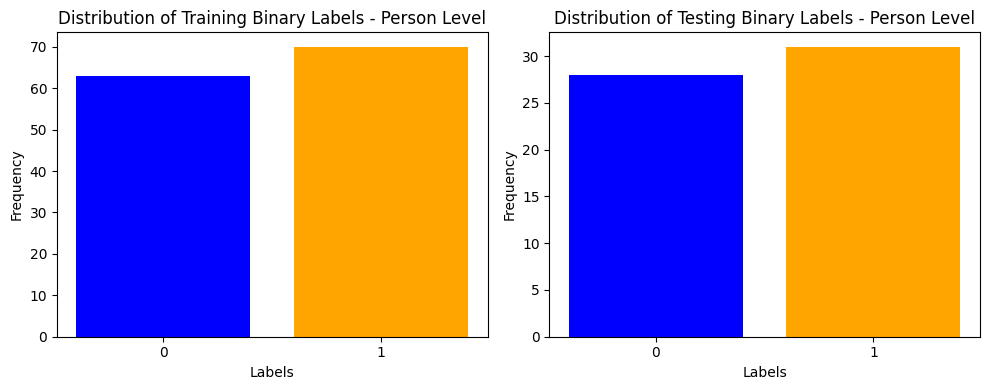

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].bar(
    [0, 1],
     [train_stats_person_wise['covid_count'], train_stats_person_wise['no_covid_count']],
    tick_label=train_unique_labels,
    color=['blue', 'orange']
)
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Training Binary Labels - Person Level')


axs[1].bar(
    [0, 1],
     [test_stats_person_wise['covid_count'], test_stats_person_wise['no_covid_count']],
    tick_label=train_unique_labels,
    color=['blue', 'orange']
)
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Testing Binary Labels - Person Level')

plt.tight_layout()
plt.show()

**NOTE:** We see that while the dataset is not balanced at the image-level, it is balanced at the person-level. Since all analysis is done at the person-level, this dataset can be considered to be balanced

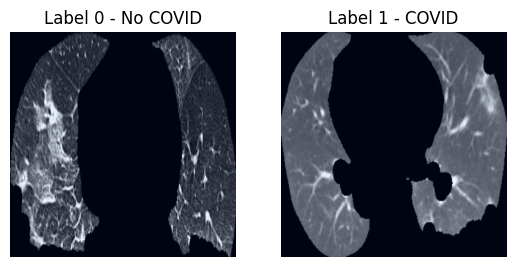

In [ ]:
# Sample training images
image_0 = train[1][0].permute(1, 2, 0).numpy()
image_1 = train[0][0].permute(1, 2, 0).numpy()

image_norm_0 = (image_0 - np.min(image_0)) / (np.max(image_0) - np.min(image_0))
image_norm_1 = (image_1 - np.min(image_1)) / (np.max(image_1) - np.min(image_1))


# Display the images side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_norm_0, cmap='gray')
axes[0].set_title("Label 0 - No COVID")
axes[0].axis('off')
axes[1].imshow(image_norm_1, cmap='gray')
axes[1].set_title("Label 1 - COVID",)
axes[1].axis('off')
plt.show()

##   Model
This section contains the model definition and the traning loop. The training loop is **set to train for 1 epoch only** and is only for demonstration purposes. A model that has been more epochs (giving better performance) will be loaded later for evaluation and analysis.

### Model architecture

In the proposed architecture named DRENet [[1]](https://pubmed.ncbi.nlm.nih.gov/33705321/), global features are extracted from each CT scan image using a pretrained ResNet50 model, from which top-K lesion regions are identified as sub-images using a Feature Pyramid Network [[5]](https://arxiv.org/abs/1612.03144) module. The shared ResNet is utilized again to extract local features within the sub-images and relational features between the sub-images. These features are concatenated with the learned global features to input into MLP for the image-level prediction.




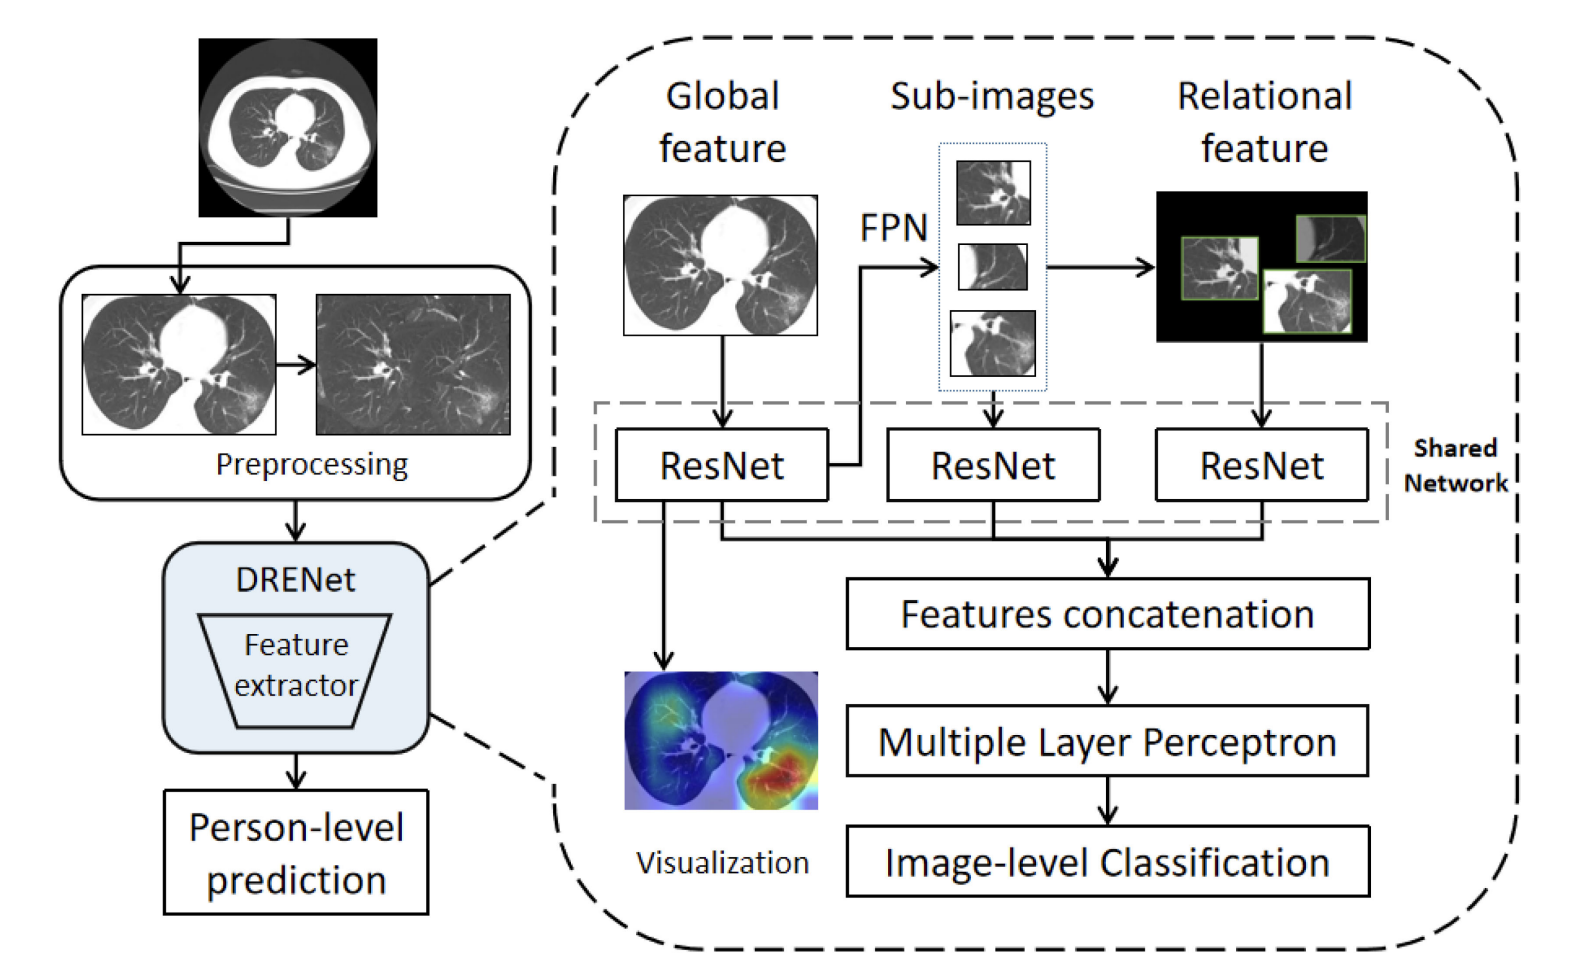


Please run the cells in this section for evaluation to work.

In [ ]:
# Please RUN this cell
# An auxillary function
def get_xy(y0, x0, y1, x1, size=448):
    pad_size = size//2

    y0 = np.max([y0, pad_size])
    y0 = np.min([y0, size+pad_size])

    x0 = np.max([x0, pad_size])
    x0 = np.min([x0, size+pad_size])

    y1 = np.max([y1, pad_size])
    y1 = np.min([y1, size+pad_size])

    x1 = np.max([x1, pad_size])
    x1 = np.min([x1, size+pad_size])

    return y0, x0, y1, x1

In [ ]:
# Please RUN this cell
# A part of the model

class ProposalNet(nn.Module):
    def __init__(self):
        super(ProposalNet, self).__init__()
        self.down1 = nn.Conv2d(2048, 128, 3, 1, 1)
        self.down2 = nn.Conv2d(128, 128, 3, 2, 1)
        self.down3 = nn.Conv2d(128, 128, 3, 2, 1)
        self.act = nn.ReLU()
        self.tidy1 = nn.Conv2d(128, 1, 1, 1, 0)
        self.tidy2 = nn.Conv2d(128, 1, 1, 1, 0)
        self.tidy3 = nn.Conv2d(128, 1, 1, 1, 0)

    def forward(self, x):
        batch_size = x.size(0)
        d1 = self.act(self.down1(x))
        d2 = self.act(self.down2(d1))
        d3 = self.act(self.down3(d2))
        t1 = self.tidy1(d1).view(batch_size, -1)
        t2 = self.tidy2(d2).view(batch_size, -1)
        t3 = self.tidy3(d3).view(batch_size, -1)
        return torch.cat((t1, t2), dim=1), t3

In [ ]:
# Please RUN this cell
# Model architecture proposed in the paper
class DRENet(nn.Module):
    def __init__(self, top_k=4, n_class=2, no_global=False, no_subimage=False, no_relational=False):
        super(DRENet, self).__init__()
        self.n_class = n_class
        self.no_global = no_global
        self.no_subimage = no_subimage
        self.no_relational = no_relational
        self.pretrained_model = resnet.resnet50(pretrained=True)
        self.proposal_net = ProposalNet()
        self.top_k = top_k

        self.pretrained_model.avgpool = nn.AdaptiveAvgPool2d(1)
        self.pretrained_model.fc = nn.Linear(512 * 4, self.n_class)

        concat_dim = CAT_NUM + 1 + 1
        concat_dim -= int(self.no_global) + int(self.no_relational)

        if self.no_subimage:
            concat_dim -= CAT_NUM
        else:
            self.partcls_net = nn.Linear(512 * 4, self.n_class)
        self.pad_size = 224
        _, edge_anchors_small, _ = generate_default_anchor_maps(setting='small')
        self.edge_anchors_small = (edge_anchors_small + 224).astype(int)
        _, edge_anchors_large, _ = generate_default_anchor_maps(setting='large')
        self.edge_anchors_large = (edge_anchors_large + 224).astype(int)

        self.concat_net = nn.Linear(2048 * (concat_dim), self.n_class)


    def _func(self, x, rpn_score, edge_anchors):
        all_cdds = [
            np.concatenate((x.reshape(-1, 1),
                            edge_anchors.copy(),
                            np.arange(0, len(x)).reshape(-1, 1)), axis=1)
            for x in rpn_score.data.cpu().numpy()]
        top_n_cdds = np.array(
            [hard_nms(x, topn=self.top_k//2, iou_thresh=0.1) for x in all_cdds]
        )
        # top_n_cdds = np.array(top_n_cdds)
        top_n_index = top_n_cdds[:, :, -1].astype(int)
        top_n_index = torch.from_numpy(top_n_index).cuda()
        top_n_prob = torch.gather(rpn_score, dim=1, index=top_n_index)
        return top_n_cdds, top_n_prob


    def forward(self, x, img_raw, add=False, return_vis=False):
        resnet_out, rpn_feature, feature = self.pretrained_model(x)
        batch = x.size(0)
        rpn_score_small, rpn_score_large = self.proposal_net(rpn_feature.detach())
        top_n_cdds_small, top_n_prob_small = self._func(x, rpn_score_small, self.edge_anchors_small)
        top_n_cdds_large, top_n_prob_large = self._func(x, rpn_score_large, self.edge_anchors_large)

        if not self.no_subimage:
            x_pad = F.pad(x, (self.pad_size, self.pad_size,
                            self.pad_size, self.pad_size), mode='constant', value=0)

            part_imgs = torch.zeros([batch, self.top_k, 3, 224, 224]).cuda()
            for i in range(batch):
                for j in range(self.top_k//2):
                    [y0, x0, y1, x1] = top_n_cdds_small[i][j, 1:5].astype(int)
                    part_imgs[i:i + 1, j] = F.interpolate(
                        x_pad[i:i + 1, :, y0:y1, x0:x1],
                        size=(224, 224),
                        mode='bilinear',
                        align_corners=True)

                    [y0, x0, y1, x1] = top_n_cdds_large[i][j, 1:5].astype(int)
                    part_imgs[i:i + 1, j+self.top_k//2] = F.interpolate(
                        x_pad[i:i + 1, :, y0:y1, x0:x1],
                        size=(224, 224),
                        mode='bilinear',
                        align_corners=True)

            part_imgs = part_imgs.view(batch * self.top_k, 3, 224, 224)
            temp, _, sub_image_feats = self.pretrained_model(part_imgs.detach())
            sub_image_feat = sub_image_feats.view(batch, self.top_k, -1)
            sub_image_feat = sub_image_feat[:, :CAT_NUM, ...]
            sub_image_feat = sub_image_feat.contiguous().view(batch, -1)

        if not self.no_relational:
            x2 = x.clone()
            if add:
                for bs in range(batch):
                    [y0, x0, y1, x1] = top_n_cdds_large[bs][0, 1:5].astype(int)
                    y0, x0, y1, x1 = get_xy(y0, x0, y1, x1)
                    y0 = int((y0 - 224)/448*600)
                    x0 = int((x0 - 224)/448*600)
                    y1 = int((y1 - 224)/448*600)
                    x1 = int((x1 - 224)/448*600)
                    x2[bs] = F.interpolate(
                            img_raw[bs:bs + 1, :, y0:y1, x0:x1],
                            size=(448, 448),
                            mode='bilinear',
                            align_corners=True)
            _, _, feature2 = self.pretrained_model(x2.detach()) #


        raw_logits, concat_logits, part_logits, top_n_index, top_n_prob = None, None, None, None, None

        if self.no_global:
             concat_out = torch.cat([sub_image_feat, feature2], dim=1)
             concat_logits = self.concat_net(concat_out)
             raw_logits = resnet_out
             part_logits = self.partcls_net(sub_image_feats).view(batch, self.top_k, -1)
             top_n_prob = torch.cat([top_n_prob_small, top_n_prob_large], 1)

        elif self.no_subimage:
            concat_out = torch.cat([feature, feature2], dim=1)
            concat_logits = self.concat_net(concat_out)
            raw_logits = resnet_out

        elif self.no_relational:
            concat_out = torch.cat([sub_image_feat, feature], dim=1)
            concat_logits = self.concat_net(concat_out)
            raw_logits = resnet_out
            part_logits = self.partcls_net(sub_image_feats).view(batch, self.top_k, -1)
            top_n_prob = torch.cat([top_n_prob_small, top_n_prob_large], 1)

        else:
            concat_out = torch.cat([sub_image_feat, feature, feature2], dim=1)
            concat_logits = self.concat_net(concat_out)
            raw_logits = resnet_out
            part_logits = self.partcls_net(sub_image_feats).view(batch, self.top_k, -1)
            top_n_prob = torch.cat([top_n_prob_small, top_n_prob_large], 1)

        return [raw_logits, concat_logits, part_logits, top_n_index, top_n_prob]

### Training and Evaluation Functions

In [ ]:
def compute_loss(raw_logits, concat_logits, part_logits, labels, top_n_prob):
    raw_loss, rank_loss, concat_loss, partcls_loss = 0, 0, 0, 0

    if part_logits is not None:
        part_loss = losses.list_loss(
            part_logits.view(-1, part_logits.size(-1)),
            labels.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)
        ).view(labels.size(0), PROPOSAL_NUM)

        rank_loss = losses.ranking_loss(top_n_prob, part_loss)

        partcls_loss = creterion(
            part_logits.view(-1, part_logits.size(-1)),
            labels.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)
        )

    if raw_logits is not None:
        raw_loss = creterion(raw_logits, labels)

    if concat_logits is not None:
        concat_loss = creterion(concat_logits, labels)

    total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
    return total_loss

def compute_person_wise_metrics(people_lst, pred_logits, auc_label_lst):
    i = 0
    score = defaultdict(list)
    label = {}
    for people_tuple in people_lst:
        for person in people_tuple:
            label[person] = auc_label_lst[i]
            score[person].append(pred_logits[i])
            i += 1
    score_mean = {k : np.mean(v) for k, v in score.items()}

    person_wise_label = []
    person_wise_score = []
    for person, score in score_mean.items():
        person_wise_label.append(label[person])
        person_wise_score.append(score_mean[person])
    return {
        "roc_auc" : roc_auc_score(person_wise_label, person_wise_score),
        "person_wise_label" : person_wise_label,
        "person_wise_score" : person_wise_score
    }


In [ ]:
# Training function

def train_drenet(net, device, trainloader, valloader, num_epochs=50, outfile='val_best_model'):
    skip_epoch = 0
    best = 0
    for epoch in range(0, num_epochs):
        print("Epoch", epoch)
        if epoch > skip_epoch:
            add = True
        else:
            add = False

        net.train()
        train_correct = 0
        total = 0
        for i, data in enumerate(tqdm(trainloader)):
            img, label, img_raw = data[0].to(device), data[1].to(device), data[2]
            batch_size = img.size(0)
            optimizer.zero_grad()
            raw_logits, concat_logits, part_logits, _, top_n_prob = net(img, img_raw, add)
            loss = compute_loss(raw_logits, concat_logits, part_logits, label, top_n_prob)
            # total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            _, concat_predict = torch.max(concat_logits, 1)
            total += batch_size
            train_correct += torch.sum(concat_predict.data == label.data)

        print("training acc: ", float(train_correct) / total)
        with open('./model.pkl', 'wb') as f:
            pickle.dump(net, f)

        if epoch % EVAL_FREQ == 0 :
            net.eval()
            val_loss, val_correct, total = 0, 0, 0
            auc_label_lst, auc_pred_lst, people_lst, file_name_lst = [], [], [], []
            for i, data in enumerate(tqdm(valloader)):
                with torch.no_grad():
                    img, label, img_raw = data[0].to(device), data[1].to(device), data[2]
                    batch_size = img.size(0)
                    _, concat_logits, _, _, _, = net(img, img_raw, add)
                    concat_loss = creterion(concat_logits, label)
                    _, concat_predict = torch.max(concat_logits, 1)
                    auc_label_lst += list(label.data.cpu().numpy())
                    pred = F.softmax(concat_logits, dim=1)
                    auc_pred_lst.append(pred.data.cpu().numpy())
                    people_lst.append(data[3])
                    file_name_lst.append(data[4])

                    total += batch_size
                    val_correct += torch.sum(concat_predict.data == label.data)
                    val_loss += concat_loss.item() * batch_size

            val_acc = float(val_correct) / total
            val_loss = val_loss / total

            pred_logits = np.concatenate(auc_pred_lst, 0)[:, 1]
            person_wise_auc = compute_person_wise_metrics(people_lst,  pred_logits, auc_label_lst)['roc_auc']
            print(f"Person-wise testing AUC : {person_wise_auc:.4f}")
            auc = roc_auc_score(auc_label_lst, np.concatenate(auc_pred_lst, 0)[:, 1])
            if person_wise_auc > best:
                best = person_wise_auc
                with open(f'./{outfile}_{epoch}.pkl', 'wb') as f:
                    pickle.dump(net, f)
                torch.save(net.state_dict(), f'{outfile}_{epoch}.pt')

    print('finished training')

In [ ]:
def evaluate(trained_net, testloader, seed=101, decision_threshold=0.5):
    # Evaluate on test set
    test_loss = 0
    test_correct = 0
    total = 0
    auc_label_lst = []
    auc_pred_lst = []
    people_lst = []
    img_vis_lst = []
    file_name_lst = []
    anchor_lst = []
    add=False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    for i, data in enumerate(tqdm(testloader)):
        with torch.no_grad():
            img, label, img_raw = data[0].to(device), data[1].to(device), data[2]
            batch_size = img.size(0)
            _, concat_logits, _, _, _ = trained_net(img, img_raw, add, False)
            _, concat_predict = torch.max(concat_logits, 1)
            auc_label_lst += list(label.data.cpu().numpy())
            pred = torch.nn.Softmax(1)(concat_logits)
            auc_pred_lst.append(pred.data.cpu().numpy())
            people_lst.append(data[3])
            file_name_lst += list(data[4])
            total += batch_size
            test_correct += torch.sum(concat_predict.data == label.data)
    test_acc = float(test_correct) / total
    pred_logits = np.concatenate(auc_pred_lst, 0)[:, 1]
    metrics = compute_person_wise_metrics(people_lst,  pred_logits, auc_label_lst)
    person_wise_auc = metrics['roc_auc']

    print(f'\nPerson-wise ROC-AUC: {person_wise_auc:.4f}')

    predictions =  (np.array(metrics['person_wise_score']) > decision_threshold).astype(int)
    return metrics['person_wise_label'], predictions

## Sample Training

In [ ]:
n_class = 2
net = DRENet(top_k=PROPOSAL_NUM, n_class=n_class)
net.to(device)

creterion = torch.nn.CrossEntropyLoss()
parameters = list(net.parameters())
optimizer = torch.optim.SGD(parameters, lr=LR, momentum=0.9, weight_decay=WD)
scheduler = MultiStepLR(optimizer, milestones=[60, 100], gamma=0.1)

# Sample training for 1 epoch
train_drenet(net, device, trainloader, testloader, num_epochs=1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


Epoch 0


100%|██████████| 287/287 [02:47<00:00,  1.72it/s]


training acc:  0.7578397212543554


100%|██████████| 142/142 [00:33<00:00,  4.22it/s]


Person-wise testing AUC : 0.8168
finished training


## Hyperparameters and implementation details



1.   Learning rate: the paper suggests using a learning rate of 8e-4. A higher learning rate (1e-3) led to unstable traning. Slower learning rates (1e-4, 5e-5) led to similar results when trained for 50 epochs.
2.   Number of epochs: For all experiments, training was carried out for 50 epochs, though the models were evaluated after each epoch, and the model with the highest person-level ROC-AUC on the (custom) validation set was chosen as the final model for each experiment
3. Momentum of 0.9 and weight decay of 1e-4 are used
4. Batch size of 4 was used. A larger batch size can lead to GPU memory issues.
5. Training can conviniently be performed using T4 GPU on Colab. It takes ~3 minutes per epoch of training.  
6. This notebook was tested using Python 3.10.12


# Model Results



We use standard classification metrics to evaluate performance. The metrics are described below:

1. **Precision**: Precision measures the proportion of true positive predictions among all positive predictions made by the model. It indicates how many of the positively labeled instances were correctly identified by the model. \
Precision = True Positives / (True Positives + False Positives)


2. **Recall** (Sensitivity): Recall measures the proportion of true positive predictions among all actual positive instances in the dataset. It indicates the model's ability to correctly identify all positive instances. \
Recall = True Positives / (True Positives + False Negatives)

3. **F1 Score**: F1 Score is the harmonic mean of precision and recall.It Score reaches its best value at 1 (perfect precision and recall) and worst at 0. \
F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

4. **ROC-AUC** (Receiver Operating Characteristic - Area Under Curve): ROC-AUC is a performance measurement for classification problems at various threshold settings. It plots the true positive rate (recall) against the false positive rate (1-specificity) for different threshold values. The area under the ROC curve (AUC) measures the model's ability to distinguish between positive and negative classes. A higher AUC indicates better model performance.

5. **Accuracy**: Accuracy measures the proportion of correct predictions among the total number of predictions made by the model. \
Accuracy = (True Positives + True Negatives) / Total Predictions

In [ ]:
# Download best pretrained model
# Saves as val_best_model_14.pt
!gdown 1yZVg9e8F7Y782peLYe9QyWmK4zhcjJzS

Downloading...
From (original): https://drive.google.com/uc?id=1yZVg9e8F7Y782peLYe9QyWmK4zhcjJzS
From (redirected): https://drive.google.com/uc?id=1yZVg9e8F7Y782peLYe9QyWmK4zhcjJzS&confirm=t&uuid=2dbbd78a-6bf2-44bc-887c-9f19aaf1de23
To: /content/dl4h/val_best_model_14.pt
100% 105M/105M [00:00<00:00, 165MB/s] 


In [ ]:
# Load pretrained network
n_class = 2
trained_net = DRENet(top_k=PROPOSAL_NUM, n_class=n_class)
trained_net.load_state_dict(torch.load('val_best_model_14.pt'))
trained_net = trained_net.to(device)
person_wise_labels, person_wise_preds = evaluate(trained_net, testloader)
print(classification_report(person_wise_labels, person_wise_preds))

100%|██████████| 142/142 [00:34<00:00,  4.14it/s]



Person-wise ROC-AUC: 0.9067
              precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       0.79      0.96      0.87        28

    accuracy                           0.86        59
   macro avg       0.88      0.87      0.86        59
weighted avg       0.88      0.86      0.86        59



The ROC-AUC, while good,  is lower than reported in the paper (0.95). However, all the other metrics - precision, recall, F1-score, and accuracy match the paper, using the standard decision threshold of 0.5

We see a high Recall for the COVID class (class 1). This is great as it means the number of actual COVID patients who will miss treatment (due to misprediction) will be low (though ideally we want it to be 0).

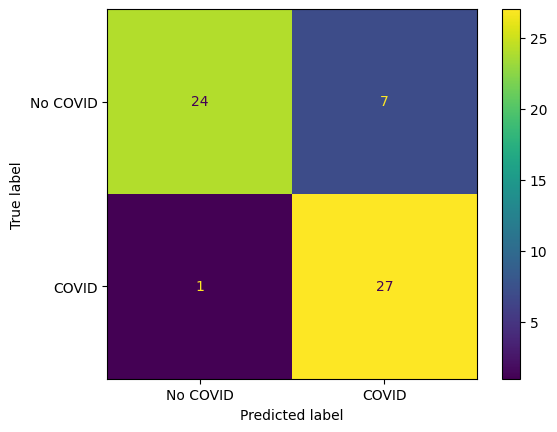

In [ ]:
cm = confusion_matrix(person_wise_labels, person_wise_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No COVID", "COVID"])
disp.plot()
plt.show()

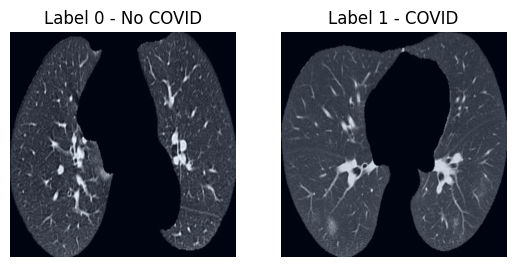

In [ ]:
# Sample testing images
image_0 = test[3][0].permute(1, 2, 0).numpy()
image_1 = test[0][0].permute(1, 2, 0).numpy()

image_norm_0 = (image_0 - np.min(image_0)) / (np.max(image_0) - np.min(image_0))
image_norm_1 = (image_1 - np.min(image_1)) / (np.max(image_1) - np.min(image_1))


# Display the images side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_norm_0, cmap='gray')
axes[0].set_title("Label 0 - No COVID")
axes[0].axis('off')
axes[1].imshow(image_norm_1, cmap='gray')
axes[1].set_title("Label 1 - COVID",)
axes[1].axis('off')
plt.show()

# Ablation Studies
As described above, the DRENet architecture uses three types of features - (1) global, (2) sub-image, and (3) relational. Three ablation studies have been performed where one of the three features is omitted in each study. The DRENet model definition is modified to accomodate the ablations using arguments `no_global`, `no_subimage`, and `no_relational` . Below, sample training code is provided for each ablation study. Then a trained model for each study is loaded for evaluation.

## Ablation 1: Remove Global Features

In [ ]:
# Sample training for 1 epoch
n_class = 2
net = DRENet(top_k=PROPOSAL_NUM, n_class=n_class, no_global=True)


creterion = torch.nn.CrossEntropyLoss()
parameters = list(net.parameters())
optimizer = torch.optim.SGD(parameters, lr=LR, momentum=0.9, weight_decay=WD)
scheduler = MultiStepLR(optimizer, milestones=[60, 100], gamma=0.1)


net.to(device)
train_drenet(net, device, trainloader, testloader, num_epochs=1, outfile='val_best_model_ab1_demo')

In [ ]:
# Download best model for ablation - 1
# Saves as val_best_model_ab1_5.pt
!gdown 1Bxxh2kQyFHROcJ0itxL2TbZSEsWm_xP8

Downloading...
From (original): https://drive.google.com/uc?id=1Bxxh2kQyFHROcJ0itxL2TbZSEsWm_xP8
From (redirected): https://drive.google.com/uc?id=1Bxxh2kQyFHROcJ0itxL2TbZSEsWm_xP8&confirm=t&uuid=f02f1a8d-0869-4bfe-bd48-a4e6eed2eefa
To: /content/dl4h/val_best_model_ab1_5.pt
100% 105M/105M [00:01<00:00, 55.7MB/s]


In [ ]:
trained_net = DRENet(top_k=PROPOSAL_NUM, n_class=2, no_global=True)
trained_net.load_state_dict(torch.load('val_best_model_ab1_5.pt'))
trained_net = trained_net.to(device)
person_wise_labels, person_wise_preds = evaluate(trained_net, testloader)
print(classification_report(person_wise_labels, person_wise_preds))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]
100%|██████████| 142/142 [00:36<00:00,  3.88it/s]


Person-wise ROC-AUC: 0.8882
              precision    recall  f1-score   support

           0       1.00      0.65      0.78        31
           1       0.72      1.00      0.84        28

    accuracy                           0.81        59
   macro avg       0.86      0.82      0.81        59
weighted avg       0.87      0.81      0.81        59



## Ablation 2: Remove Sub-Image Features

In [ ]:
# Sample training for 1 epoch
n_class = 2
net = DRENet(top_k=PROPOSAL_NUM, n_class=n_class, no_subimage=True)
net.to(device)

creterion = torch.nn.CrossEntropyLoss()
parameters = list(net.parameters())
optimizer = torch.optim.SGD(parameters, lr=LR, momentum=0.9, weight_decay=WD)
scheduler = MultiStepLR(optimizer, milestones=[60, 100], gamma=0.1)


train_drenet(net, device, trainloader, testloader, num_epochs=1, outfile='val_best_model_ab2_demo')

In [ ]:
# Download best model for ablation - 2
# Saves as val_best_model_ab2_31.pt
!gdown 193aZpyeViKrJRzO_wvZb_LAwIaOg2DAu

Downloading...
From (original): https://drive.google.com/uc?id=193aZpyeViKrJRzO_wvZb_LAwIaOg2DAu
From (redirected): https://drive.google.com/uc?id=193aZpyeViKrJRzO_wvZb_LAwIaOg2DAu&confirm=t&uuid=cef18f7a-4869-476d-952c-22406d046fe3
To: /content/dl4h/val_best_model_ab2_31.pt
100% 105M/105M [00:00<00:00, 199MB/s] 


In [ ]:
trained_net = DRENet(top_k=PROPOSAL_NUM, n_class=2, no_subimage=True)
trained_net.load_state_dict(torch.load('val_best_model_ab2_31.pt'))
trained_net = trained_net.to(device)
person_wise_labels, person_wise_preds = evaluate(trained_net, testloader)
print(classification_report(person_wise_labels, person_wise_preds))

100%|██████████| 142/142 [00:22<00:00,  6.24it/s]


Person-wise ROC-AUC: 0.9032
              precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       0.79      0.96      0.87        28

    accuracy                           0.86        59
   macro avg       0.88      0.87      0.86        59
weighted avg       0.88      0.86      0.86        59



## Ablation 3: Remove Relational Features

In [ ]:
# Sample training for 1 epoch
n_class = 2
net = DRENet(top_k=PROPOSAL_NUM, n_class=n_class, no_relational=True)
net.to(device)

creterion = torch.nn.CrossEntropyLoss()
parameters = list(net.parameters())
optimizer = torch.optim.SGD(parameters, lr=LR, momentum=0.9, weight_decay=WD)
scheduler = MultiStepLR(optimizer, milestones=[60, 100], gamma=0.1)

train_drenet(net, device, trainloader, testloader, num_epochs=1, outfile='val_best_model_ab3_demo')

In [ ]:
# Download best model for ablation - 3
# Saves as val_best_model_ab3_27.pt
!gdown 1t6WACE7EWVpl8IF6t6hT-3-zXiPIjc5r

Downloading...
From (original): https://drive.google.com/uc?id=1t6WACE7EWVpl8IF6t6hT-3-zXiPIjc5r
From (redirected): https://drive.google.com/uc?id=1t6WACE7EWVpl8IF6t6hT-3-zXiPIjc5r&confirm=t&uuid=fe582e9a-7a0c-45ca-9795-618ed4917f54
To: /content/dl4h/val_best_model_ab3_27.pt
100% 105M/105M [00:01<00:00, 90.4MB/s] 


In [ ]:
trained_net = DRENet(top_k=PROPOSAL_NUM, n_class=2, no_relational=True)
trained_net.load_state_dict(torch.load('val_best_model_ab3_27.pt'))
trained_net = trained_net.to(device)
person_wise_labels, person_wise_preds = evaluate(trained_net, testloader)
print(classification_report(person_wise_labels, person_wise_preds))

100%|██████████| 142/142 [00:26<00:00,  5.29it/s]


Person-wise ROC-AUC: 0.9182
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        31
           1       0.77      0.96      0.86        28

    accuracy                           0.85        59
   macro avg       0.86      0.85      0.85        59
weighted avg       0.87      0.85      0.85        59



A natural question arises: do we even need sub-image/relational features? We investigate that in the next section. Note that using global features alone is equivalent using just feeding the entire image to a pretrained ResNet model (that acts as a feature extractor) followed by a classification head. This is identical to the ResNet baseline in the paper, and hence is presented as a model comparision below.

## Model comparison

In [ ]:
train_path = './train/'
val_path = './val/'
test_path = './test/'

train = SARS(root=train_path, is_train=True)
val = SARS(root=val_path, is_train=False)
test = SARS(root=test_path, is_train=False)



trainloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,
                                          shuffle=True, drop_last=False)
valloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE,
                                         shuffle=False, drop_last=False)
testloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,
                                         shuffle=False, drop_last=False)

In [ ]:
# Please RUN this cell
# Model architecture proposed in the paper
class ResNet(nn.Module):
    def __init__(self, top_k=4, n_class=2):
        super(ResNet, self).__init__()
        self.n_class = n_class
        self.pretrained_model = resnet.resnet50(pretrained=True)
        self.pretrained_model.avgpool = nn.AdaptiveAvgPool2d(1)
        self.pretrained_model.fc = nn.Linear(512 * 4, self.n_class)
        concat_dim = 1
        self.concat_net = nn.Linear(2048 * (concat_dim), self.n_class)

    def forward(self, x, img_raw, add=False, return_vis=False):
        resnet_out, rpn_feature, feature = self.pretrained_model(x)
        concat_out = torch.cat([feature], dim=1)
        concat_logits = self.concat_net(concat_out)
        raw_logits = resnet_out
        return [raw_logits, concat_logits, None, None, None]

In [ ]:
# Sample training 1 epoch
# n_class = 2
# net = ResNet(top_k=PROPOSAL_NUM, n_class=n_class)
# net.to(device)

# creterion = torch.nn.CrossEntropyLoss()
# parameters = list(net.parameters())
# optimizer = torch.optim.SGD(parameters, lr=LR, momentum=0.9, weight_decay=WD)
# scheduler = MultiStepLR(optimizer, milestones=[60, 100], gamma=0.1)

# train_drenet(net, device, trainloader, testloader, num_epochs=1, outfile='val_resnet_model')

In [ ]:
!gdown 1NPDeb6VTa7gDMhwyAAXkMhrvBT_qWTw3

Downloading...
From (original): https://drive.google.com/uc?id=1NPDeb6VTa7gDMhwyAAXkMhrvBT_qWTw3
From (redirected): https://drive.google.com/uc?id=1NPDeb6VTa7gDMhwyAAXkMhrvBT_qWTw3&confirm=t&uuid=411c292a-b21f-40e6-8222-e3d67c2283b7
To: /content/dl4h/val_resnet_model_30e_24.pt
100% 94.4M/94.4M [00:00<00:00, 99.3MB/s]


In [ ]:
trained_net = ResNet(top_k=PROPOSAL_NUM, n_class=2)
trained_net.load_state_dict(torch.load('val_resnet_model_30e_24.pt'))
trained_net = trained_net.to(device)
person_wise_labels, person_wise_preds = evaluate(trained_net, testloader)
print(classification_report(person_wise_labels, person_wise_preds))

100%|██████████| 142/142 [00:15<00:00,  8.90it/s]


Person-wise ROC-AUC: 0.9055
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        31
           1       0.80      1.00      0.89        28

    accuracy                           0.88        59
   macro avg       0.90      0.89      0.88        59
weighted avg       0.91      0.88      0.88        59



# Results and Analysis

The results from the experiments and the paper are tabulated below (all metrics correspond to class-1 : COVID):

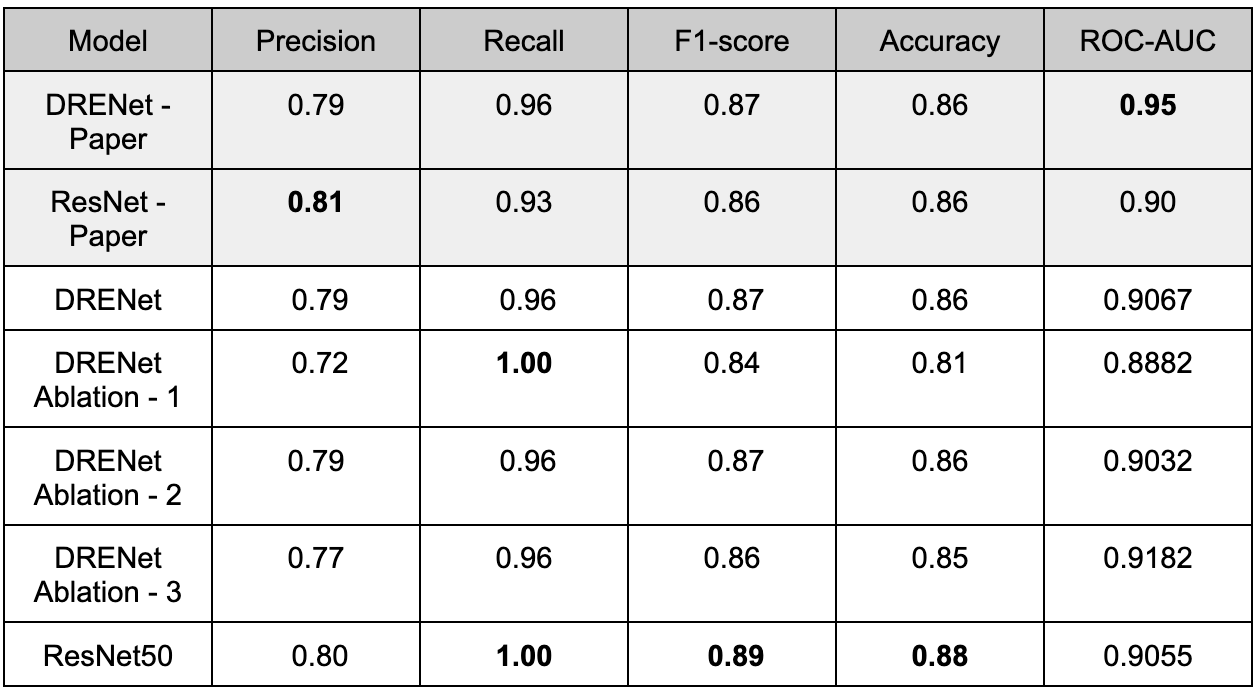



We observe the following:


1.   The results for DRENet in the paper and in my implementation match in all metrics except ROC-AUC.
2.   Among the ablation studies, ablation study 1 (removing global features) shows the largest dip in performance highlighting the significance of global features.
3. The significance of the sub-image and relational features is less pronounced since (i) ablation studies 2 and 3 do not show a major dip in performance, and (ii) the ResNet50 implementation (which essentially is the same setting as "global features only") marginally better results than DRENet.
4. **Recall is very high in all models, which is good for a task like COVID-19 prediction since no infected person will miss treatment.**






# Discussion/Conclusions

<!-- In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase. -->



- This paper is reproducible for the binary classification task.
- Hypothesis 1 has been tested. The results obtained for the DRENet model match the paper in all metrics other than ROC-AUC.
- For Hypothesis 2, un my experiments, the performance ResNet50 is marginally better than DRENet in terms of accuracy and F1-score, while the paper claims similar performance for the two models.
- The ablation studies and the model comparision suggest that global features are the most important component in the DRENet architecture.
- The code provided by the authors of the original paper makes it convinient to replicate the model archiecture. However, missing details (like hyperparameters) and errors in the data released make it difficult to replcate the same performance.

# References

1.  Song, Ying et al. “Deep Learning Enables Accurate Diagnosis of Novel Coronavirus (COVID-19) With CT Images.” IEEE/ACM transactions on computational biology and bioinformatics vol. 18,6 (2021): 2775-2780. doi:10.1109/TCBB.2021.3065361

2. Kuzinkovas, D.; Clement, S. The Detection of COVID-19 in Chest X-rays Using Ensemble CNN Techniques. Information 2023, 14, 370. https://doi.org/10.3390/info14070370

3. Ullah, Z., Usman, M., Latif, S. et al. Densely attention mechanism based network for COVID-19 detection in chest X-rays. Sci Rep 13, 261 (2023). https://doi.org/10.1038/s41598-022-27266-9

4. A. Arivoli, Devdatt Golwala, Rayirth Reddy,
CoviExpert: COVID-19 detection from chest X-ray using CNN,
Measurement: Sensors,
Volume 23,
2022,
100392,
ISSN 2665-9174,
https://doi.org/10.1016/j.measen.2022.100392.


5.   Lin T.-Y. et al. “Feature pyramid networks for object detection,” in Proc. IEEE Conf. Comput. Vis. Pattern Recognit., 2017, pp. 936–944.

6.  K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.

